In [7]:
import sys
dirname = '../../../'
sys.path.insert(0, dirname+'figures')
sys.path.insert(0, dirname+'network')
import plot_utils as pu
import color_scheme as cs

In [8]:
import pdb
import sys
import argparse
import itertools

import numpy as np
from scipy.stats import norm, binned_statistic
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

Load data from figure 1

In [9]:
data = np.load(open(dirname+"figures/article/4/data/data_bcd.npy", "rb"), allow_pickle=True)
overlaps, state = data[2], data[0]
tau = 10.

Load peak data

In [12]:
peaks = np.load("data/data.npy", allow_pickle=True)[0]

Compute data for panel a

In [13]:
width = []
midpoint = []
for n, unit in enumerate(peaks):
    for peak in unit:
        if len(peak) == 0:
            continue
        else:
            # Skip empty peaks
            if len(peak) == 1:
                continue
            # Skip peaks that are maximal at t=0
            elif peak[1:][0] == 1 and np.argmax(peak[1:]) == 0:
                continue
            # Record weighted average time
            else:
                t = peak[1:]
                r = state[n,t]
                width.append(t[-1]-t[0])
                midpoint.append(sum(r * t) / r.sum())

def sqrt_fun(a, b, t):
    return a*np.sqrt(b*t)
def fun(x):
    a, b = x
    if b < 0: b = 0
    return sum((width - sqrt_fun(a, b, np.asarray(midpoint)))**2)
res = minimize(fun, [tau,1./tau])
print(res)

bins = np.arange(0,3100,10)
mean = binned_statistic(midpoint, width, statistic='mean', bins=bins)[0]
std = binned_statistic(midpoint, width, statistic='std', bins=bins)[0]

      fun: 19437783.39798458
 hess_inv: array([[7.88567899e-07, 8.55869049e-09],
       [8.55869049e-09, 2.50972601e-10]])
      jac: array([0.5, 9. ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 266
      nit: 13
     njev: 64
   status: 2
  success: False
        x: array([10.16662211,  0.08993217])


Compute data for panel b

In [14]:
def compute_bounds(i, x, p=0.95):
    n = 1
    clip = lambda y: np.clip(y, 0, len(x)-1)
    while True:               
        mass = x[clip(i-n):clip(i+n)].sum()
        if mass >= p*x.sum():
            break
        else:
            n += 1
    return clip(i-n), clip(i+n)

def compute_thresh(x, p=0.95):
    thresh = x.max()
    incr = 1e-4
    while True:               
        x_thresh = np.copy(x)
        x_thresh[x_thresh<thresh] = 0
        if x_thresh.sum() >= p*x.sum():
            break
        else:
            thresh -= incr
    return thresh

from connectivity import ThresholdPlasticityRule
plasticity = ThresholdPlasticityRule(x_f=1.645, q_f=0.8)
thresh = 2*np.sqrt(norm.expect(lambda x: plasticity.g(x)**2))/np.sqrt(40000)

# Computed threshold
widths_2 = []
for m in overlaps[1:]:
    m[m<thresh] = 0 
    t = np.arange(len(m))
    t_mean = sum(m * t) / m.sum()
    sigma = np.sqrt(sum(m * (t - t_mean)**2) / m.sum())
    widths_2.append(sigma)

Compute data for panel c

In [15]:
# Cumulative distribution of single unit peak times (all peaks)
T = overlaps[-1].argmax()
dt = 1e-3
b = np.histogram(midpoint, bins=T, range=(0,T))[0][:]
b = np.cumsum(b).astype(float)
b /= b[-1]

# Cumulative distribution of overlap peak times
P = overlaps.shape[0]
c = np.asarray([np.argmax(m) for m in overlaps[:,:T]]).astype(float)
d = np.histogram(c, bins=T, range=(0,T))[0]/float(T)
e = np.cumsum(d)
e /= e[-1]

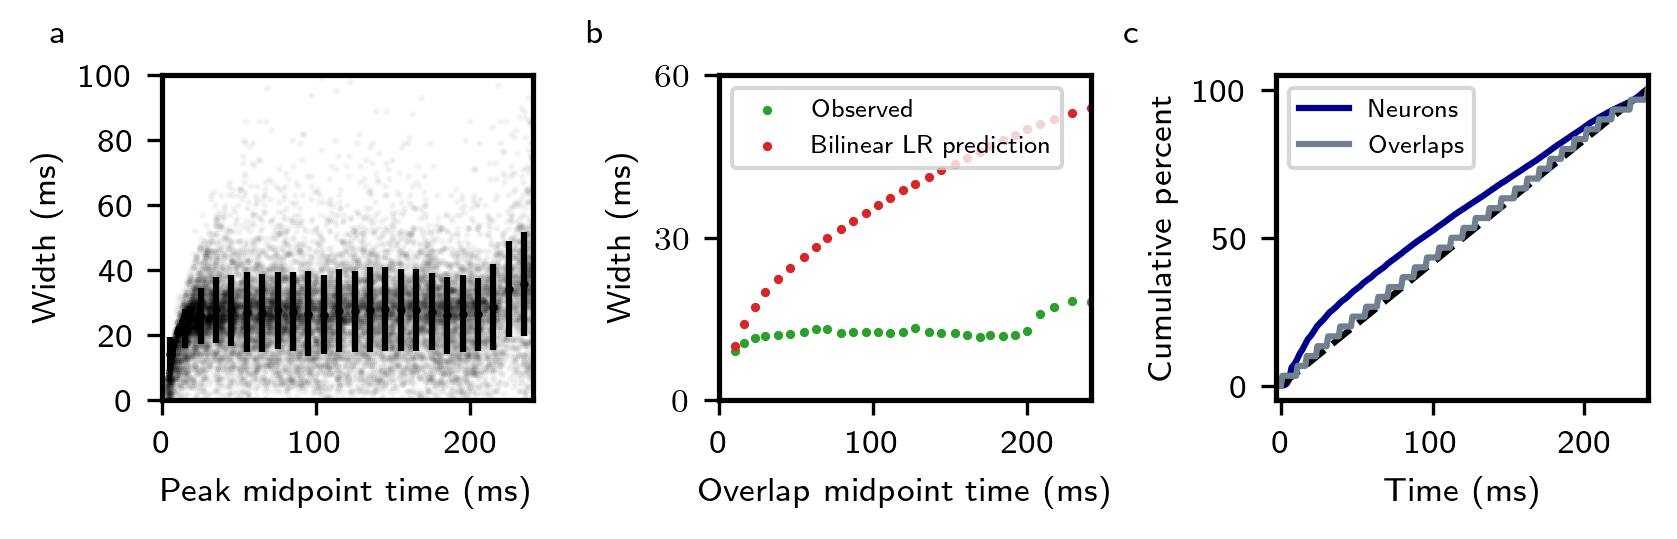

In [35]:
pu.figure_setup()
#fig_size = pu.get_fig_size(12, 4)
fig_size = pu.get_fig_size(14.8, 4.75)
fig, ax = plt.subplots(1, 3, figsize=fig_size)
plt.subplots_adjust(bottom=0.3, left=0.10, right=0.95, wspace=0.45)

ax[0].annotate("a", xy=(0.03,0.92), xycoords='figure fraction', fontsize=8)
ax[1].annotate("b", xy=(0.35,0.92), xycoords='figure fraction', fontsize=8)
ax[2].annotate("c", xy=(0.67,0.92), xycoords='figure fraction', fontsize=8)


n = 2 # Skip every n
x = np.linspace(0,200,1000)
ax[0].errorbar(
    bins[:-1]+5,
    mean,
    std,
    linestyle='None',
    marker='o',
    markersize=1,
    color='k')
ax[0].scatter(
    midpoint[::n],
    width[::n],
    s=0.5,
    color='k',
    alpha=0.035,
    rasterized=True)
ax[0].set_ylabel("Width (ms)")
ax[0].set_xlabel("Peak midpoint time (ms)")
ax[0].set_xlim([0,T*dt*1e3])
ax[0].set_ylim([0,100])
ax[0].set_yticks([0,20,40,60,80,100])
ax[0].set_yticklabels([0,20,40,60,80,100])
ax[0].set_xticks([0,100,200])
ax[0].set_xticklabels([0,100,200])

x = [np.argmax(m) for m in overlaps[1:]]
ax[1].scatter(
    x,
    widths_2,
    s=1.5,
    label="Observed",
    color='C2')
ax[1].scatter(
    x,
    tau*np.sqrt(np.arange(1,len(x)+1)),
    s=1.5,
    label="Bilinear LR prediction",
    color='C3')
ax[1].set_ylabel("Width (ms)")
ax[1].set_xlabel("Overlap midpoint time (ms)")
ax[1].set_xticks([0,100,200,300])
ax[1].set_xticklabels([0,100,200,300])
ax[1].set_xlim([0,T*dt*1e3])
ax[1].set_ylim([0,60])
ax[1].set_yticks([0,30,60])
ax[1].legend(loc=2)

# Panel c
x1 = np.linspace(0,T*dt,T-1)
x2 = np.linspace(0,T*dt+dt,T+1)
x3 = np.linspace(0,T*dt,T)
ax[2].plot(
    x3, b, color='darkblue', label="Neurons")
ax[2].plot(
    x1, np.linspace(0,1,T-1), color='k', linestyle='dashed')
ax[2].plot(
    x2, np.r_[0,e[:]], color='slategrey', linestyle='solid', label="Overlaps")
ax[2].set_xlabel("Time (ms)")
ax[2].set_ylabel("Cumulative percent")
ax[2].set_yticks([0, 0.5, 1])
ax[2].set_yticklabels([0, 50, 100])
ax[2].set_xticks([0,.100,.200,.300])
ax[2].set_xticklabels([0,100,200,300])
ax[2].set_xlim([-0.003,T*dt+0.001])
ax[2].legend(loc=2)
plt.subplots_adjust(wspace=0.5)

plt.savefig("../output/8.pdf", dpi=300, bbox_inches="tight")